In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from laplace import Laplace

import torch.func as func

from tqdm import tqdm

from helper_function import banana_dataloaders

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train: 1059, Val: 3179, Test: 1059


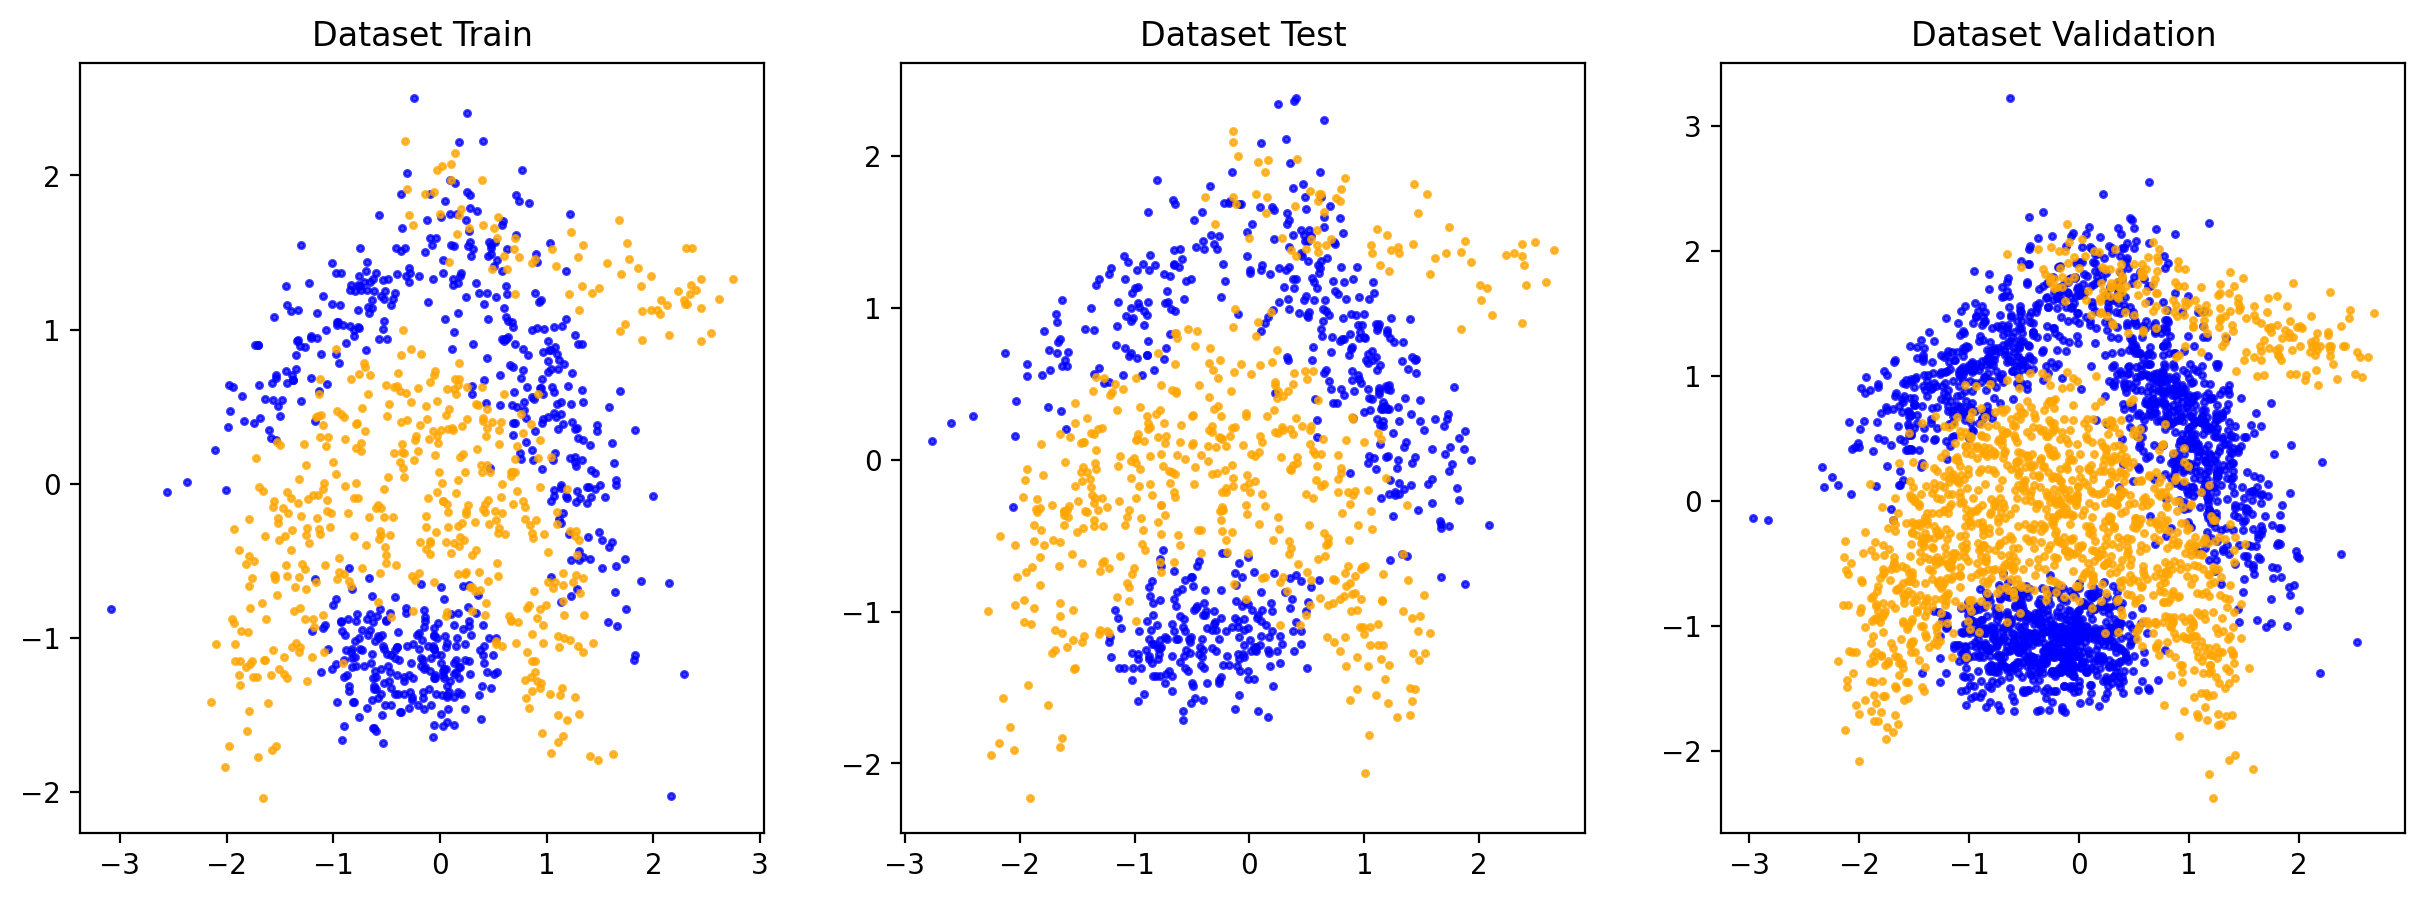

In [ ]:
train_loader, test_loader, val_loader = banana_dataloaders(train_ratio=0.2, val_ratio=0.6, test_ratio=0.2, batch_size = 64)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

for (axs, loader, name) in zip([ax1, ax2, ax3], [train_loader, test_loader, val_loader], ["Train", "Test", "Validation"]):
    x = loader.dataset.X.numpy()
    try:
        y = loader.dataset.Y.argmax(dim=1).numpy()
    except:
        y = loader.dataset.Y.numpy()
    axs.scatter(x[y == 0, 0], x[y == 0, 1], c='blue', s=5, alpha=0.75)
    axs.scatter(x[y == 1, 0], x[y == 1, 1], c='orange', s=5, alpha=0.75)
    axs.set_title(f"Dataset {name}")

In [ ]:
class TinyMLP(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=50, out_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim, bias = False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias = False)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, out_dim, bias = False)

    def forward(self, x, return_intermediate = False):
        h1 = self.fc1(x)
        a1 = self.relu1(h1)
        h2 = self.fc2(a1)
        a2 = self.relu2(h2)
        out = self.fc3(a2)
        
        if return_intermediate:
            return {'fc1': (x, h1),
                    'fc2': (a1, h2),
                    'fc3': (a2, out),
                    'logits': out
            }
        else:
            return out

100%|██████████| 500/500 [00:05<00:00, 87.25it/s]


Text(0, 0.5, 'Loss')

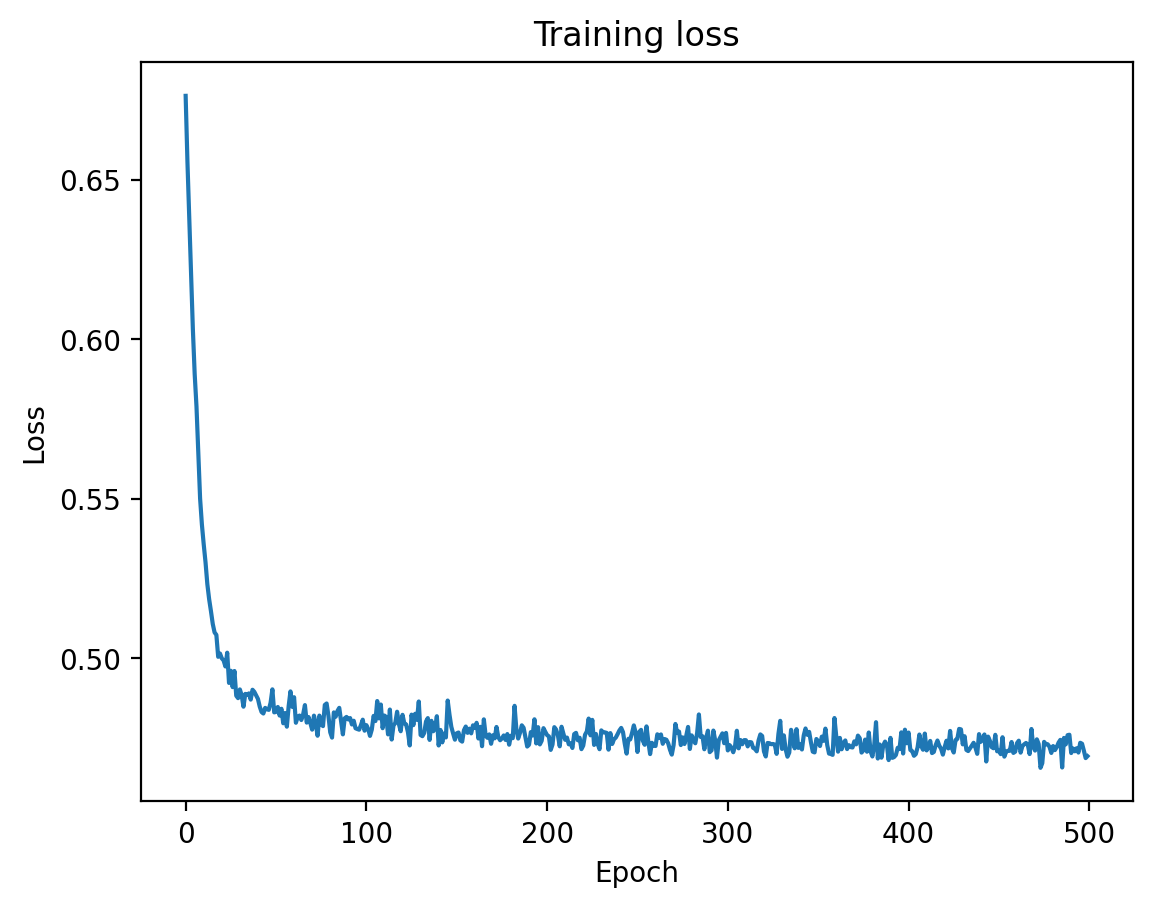

In [ ]:
model = TinyMLP()
model.to(device)

### train model
n_epochs = 500
lr = 0.001
weight_decay = 1e-5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
print_every = 20

loss_value = []

for i in tqdm(range(n_epochs)):
    
    ell = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        pred = model(X.to(device))
        loss = criterion(pred, y.to(device))
        loss.backward()
        optimizer.step()
        ell += loss.item()
        
    loss_value.append(ell/len(train_loader))
    
# plot the training loss
plt.plot(loss_value)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
from torch.func import functional_call  

def make_tail(model, start_name):
    layers = ["fc1", "relu1", "fc2", "relu2", "fc3"]
    start_idx = layers.index(start_name)
    tail_modules = [getattr(model, n) for n in layers[start_idx+1:]]

    def tail_fn(h):
        x = h
        for cur_module in tail_modules:
            if isinstance(cur_module, nn.Linear):   # linear layer needs functional call
                x = functional_call(cur_module ,
                                     dict(cur_module .named_parameters()),
                                     (x,))
            else:                                   # activation function
                x = cur_module (x)
        return x
    
    return tail_fn

def compute_A_factor(activations):
    
    """
    activations: [B, D]
    """
    
    A_factor = activations.unsqueeze(2) @ activations.unsqueeze(1)
    
    return A_factor

def compute_B_factor(jacobians, loss_wrt_output_Hessian):
    """
    jacobians: [batch_size, output_dim, hidden_dim]
    loss_wrt_output_Hessian: [batch_size, output_dim, output_dim]
    """
    
    B_factor = jacobians.transpose(1, 2) @ loss_wrt_output_Hessian @ jacobians
    
    return B_factor

def ce_loss_wrt_output_Hessian(logits):
    
    """
    logits : (B, C)  tensor
    returns: (B, C, C) Hessian blocks
    """
    p = logits.softmax(-1)  # [B, C]                   
    H = torch.diag_embed(p) - torch.einsum("bi, bj -> bij", p, p)
    return H

In [ ]:
######################################
############ test starts #############
######################################


def test_A_factor(activations):
    
    einsum_A_factor = torch.einsum('bi, bj -> bij', activations, activations)
    A_factor = compute_A_factor(activations)
    
    torch.testing.assert_close(einsum_A_factor, A_factor)

def test_B_factor(jacobians, loss_wrt_output_Hessian):
    
    einsum_B_factor = torch.einsum('bod, bop, bpe -> bde', jacobians, loss_wrt_output_Hessian, jacobians)
    B_factor = compute_B_factor(jacobians, loss_wrt_output_Hessian)
    
    torch.testing.assert_close(einsum_B_factor, B_factor)
    
B, O, D_in, D_out = 10, 4, 5, 6

A = torch.rand((B, D_in))
H = torch.rand((B, O, O))
J = torch.rand((B, O, D_out))


test_A_factor(A)

test_B_factor(J, H)


######################################
############# test ends  #############
######################################




In [ ]:
def compute_GGN_Kronecker_factors(model, data_loader):
    
    data = data_loader.dataset.X
    
    model_outputs = model(data, return_intermediate = True)

    loss_wrt_output_Hessian = ce_loss_wrt_output_Hessian(model_outputs['logits'])
    
    layer_list = ['fc1', 'fc2', 'fc3']
    GGN_kfacs = {layer_name: {'A': None, 'B': None} for layer_name in layer_list}
    
    for layer_name in layer_list:
        activation, hidden = model_outputs[layer_name]
        tail_func = make_tail(model, layer_name)
        compute_jacobian_per_datapoint = func.jacrev(tail_func)
        per_sample_jacobian = func.vmap(compute_jacobian_per_datapoint)(hidden)
        
        A_factor = compute_A_factor(activation)
        B_factor = compute_B_factor(per_sample_jacobian, loss_wrt_output_Hessian)
        
        GGN_kfacs[layer_name]['A'] = A_factor.detach()
        GGN_kfacs[layer_name]['B'] = B_factor.detach()
    
    return GGN_kfacs


In [ ]:
######################################
############ test starts #############
######################################

def test_GGN_kfacs(model, data_loader):
    from curvlinops import KFACLinearOperator
    params = [p for p in model.parameters() if p.requires_grad]
    num_params = sum(p.numel() for p in params)
    loss_function = nn.CrossEntropyLoss(reduction="sum").to(device)
    
    data = [(data_loader.dataset.X, data_loader.dataset.Y)]
    KFAC_linop = KFACLinearOperator(model, loss_function, params, data, fisher_type = 'type-2')
    
    identity = torch.eye(num_params)
    KFAC_mat = KFAC_linop @ identity
    
    GGN_kfacs = compute_GGN_Kronecker_factors(model, data_loader)
    
    for layer_name in ['fc1', 'fc2', 'fc3']:
        torch.testing.assert_close(KFAC_linop._input_covariances[layer_name], 
                                   GGN_kfacs[layer_name]['A'].mean(0))  # in curvlinops A factors are averaged
        torch.testing.assert_close(KFAC_linop._gradient_covariances[layer_name], 
                                   GGN_kfacs[layer_name]['B'].sum(0))
        
    
test_GGN_kfacs(model, train_loader)

######################################
############# test ends  #############
######################################
    

In [ ]:
def compute_log_marginal_likelihood(prior_precision, model, approx_Hess):
    """
    prior_precision: scalar
    approx_Hess: {layer_name: {'A': [B, Din, Din] , 
                               'B': [B, Dout, Dout]}
    
    """
    theta_map = torch.cat([p.view(-1).detach() for p in model.parameters()])
    num_param = theta_map.shape[0]
    first_term = torch.sum(theta_map **2) * prior_precision
    
    log_det_prior_precision = (torch.eye(num_param) * prior_precision).logdet()
    
    from laplace.utils import symeig
    log_det_posterior_precision = 0
    
    for kfacs in approx_Hess.values():
        A_fac = kfacs['A'].mean(0)
        B_fac = kfacs['B'].sum(0)
        
        A_eigenvalues, _ = symeig(A_fac)
        B_eigenvalues, _ = symeig(B_fac)
        
        log_det_posterior_precision += (torch.outer(A_eigenvalues, B_eigenvalues) + prior_precision).log().sum()
    
    log_marg_lik = -0.5 * (first_term + log_det_posterior_precision - log_det_prior_precision)
    
    return log_marg_lik
    
    

In [ ]:
######################################
############ test starts #############
######################################

def test_marginal_likelihood(model, train_loader):
    from laplace.curvature.curvlinops import CurvlinopsGGN
    la = Laplace(model, 'classification', subset_of_weights='all', hessian_structure='kron', backend = CurvlinopsGGN)
    la.fit(train_loader)
    
    for scale in [1, 10, 100]:
    
        la.prior_precision.data = torch.rand(1) * scale # [0, scale]
        
        approx_Hess = compute_GGN_Kronecker_factors(model, train_loader)
        log_marg_lik = compute_log_marginal_likelihood(la.prior_precision, model, approx_Hess)
        
        la_log_marg_lik = la.log_marginal_likelihood() - la.log_likelihood
        
        torch.testing.assert_close(log_marg_lik.item(), la_log_marg_lik.item(), atol = 1e-5, rtol = 1e-5)

test_marginal_likelihood(model, train_loader)

######################################
############ test starts #############
######################################

In [ ]:
def optimize_prior_precision(model, approx_Hessian, lr, num_epoch, verbose = False):

    prior_precision = torch.nn.Parameter(torch.tensor([1.], requires_grad=True))
    optimizer = torch.optim.Adam([prior_precision], lr, maximize=True)
    
    for epoch in range(num_epoch):
        
        optimizer.zero_grad()
        log_mag_lik = compute_log_marginal_likelihood(prior_precision, model, approx_Hessian)
        log_mag_lik.backward()
        optimizer.step()
        
        if verbose:
            print(f"Epoch {epoch}: log marg lik {log_mag_lik.item(): .3f}")
    
    return prior_precision

In [ ]:
approx_Hess = compute_GGN_Kronecker_factors(model, train_loader)
optimize_prior_precision(model, approx_Hess, 5e-2, 10, True)

Epoch 0: log marg lik -298.346
Epoch 1: log marg lik -297.459
Epoch 2: log marg lik -296.812
Epoch 3: log marg lik -296.430
Epoch 4: log marg lik -296.313
Epoch 5: log marg lik -296.411
Epoch 6: log marg lik -296.602
Epoch 7: log marg lik -296.748
Epoch 8: log marg lik -296.778
Epoch 9: log marg lik -296.704


Parameter containing:
tensor([0.7489], requires_grad=True)